## Movie Recommendation System

Data source: https://www.kaggle.com/netflix-inc/netflix-prize-data

Use **pip install -r requirements.txt** to download all required packages

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

import gc
import xgboost as xgb
# global start

### 1. Data Preprocessing

#### 1.1 Read Data

In [ ]:
# data = open('data.csv', mode='w')
# row = []
# files=['combined_data_1.txt','combined_data_2.txt', 
#         'combined_data_3.txt', 'combined_data_4.txt']
# for file in files:
#     print(f'Reading {format(file)}...')
#     with open(file) as f:
#         for line in f:
#             line = line.strip()
#             if line.endswith(':'):
#                 del row[:]
#                 movie_id = line.replace(':', '')
#             else:
#                 row = [x for x in line.split(',')]
#                 row.insert(0, movie_id)
#                 data.write(','.join(row))
#                 data.write('\n')
#     print('Done.\n')
# data.close()

Reading combined_data_1.txt...
Done.

Reading combined_data_2.txt...
Done.

Reading combined_data_3.txt...
Done.

Reading combined_data_4.txt...
Done.



In [2]:
df = pd.read_csv('data.csv', sep=',', names=['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)

# rearrange according to date?
df.sort_values(by='date', inplace=True)

In [4]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


#### 1.2 Check for Abnormal values

In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
std      1.085219e+00
Name: rating, dtype: float64

In [6]:
print(f"Num. of Nan values in the dataset: {sum(df.isnull().any())}.")

Num. of Nan values in the dataset: 0.


In [7]:
dup_bool = df.duplicated(['movie','user','rating']) # only consider 'movie','user','rating'
dups = sum(dup_bool) 
print(f"Num. of duplicate rating entries in the dataset: {dups}.")

Num. of duplicate rating entries in the dataset: 0.


#### 1.3 Basic Statistics

In [8]:
print(f"Total num. of ratings: {df.shape[0]}.")
print(f"Total num. of users: {len(np.unique(df['user']))}.")
print(f"Total num. of movies: {len(np.unique(df['movie']))}.")

Total num. of ratings: 100480507.
Total num. of users: 480189.
Total num. of movies: 17770.


### Data Analysis
#### 2.1 Split Data

In [4]:
# split data （8：1：1）
# note that the data has already been sorted by date

if not os.path.isfile('train.csv'):
    df.iloc[: int(df.shape[0] * 0.8)].to_csv('train.csv', index = False)

if not os.path.isfile('val.csv'):
    df.iloc[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.9)].to_csv('val.csv', index = False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0] * 0.9): ].to_csv('test.csv', index = False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [8]:
print("Train data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

print("\nValidation data ")
print("-"*50)
print("\nTotal no of ratings :",val_df.shape[0])
print("Total No of Users   :", len(np.unique(val_df.user)))
print("Total No of movies  :", len(np.unique(val_df.movie)))

print("\nTest data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Train data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424

Validation data 
--------------------------------------------------

Total no of ratings : 10048051
Total No of Users   : 281686
Total No of movies  : 17627

Test data 
--------------------------------------------------

Total no of ratings : 10048051
Total No of Users   : 288028
Total No of movies  : 17738


#### 2.2 Explore Train data

##### 2.2.1 Distribution of Ratings

In [11]:
def change_unit(num, units = 'm'):
    num = float(num)
    if units == 'k' or units == 'K':
        return str(num / 10 ** 3) + 'K'
    elif units == 'm' or units == 'M':
        return str(num / 10 ** 6) + 'M'
    elif units == 'b' or units == 'B':
        return str(num / 10 ** 9) + 'B'

In [18]:
n_rating_count = train_df['rating'].value_counts().sort_index()

print(n_rating_count)

rating
1     3741085
2     8369795
3    23339084
4    27161596
5    17772845
Name: count, dtype: int64


C:\Users\Churou\AppData\Local\Temp\ipykernel_17320\1881580775.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])


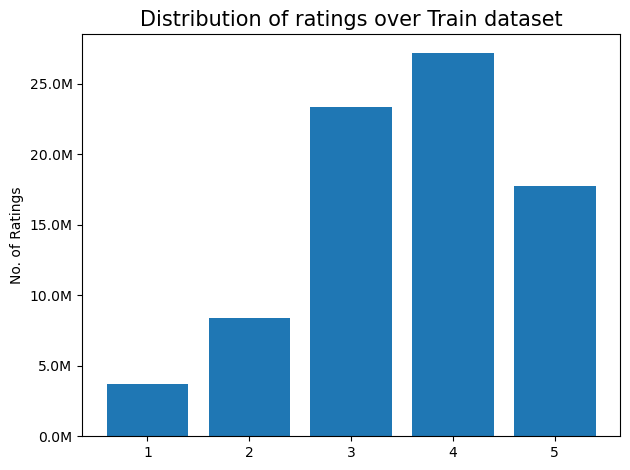

In [19]:
fig, ax = plt.subplots()
bars = ax.bar(n_rating_count.index, n_rating_count.values)

ax.set_title('Distribution of ratings over Train dataset', fontsize=15)
ax.set_ylabel('No. of Ratings')
ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])

plt.tight_layout()
plt.show()

##### 2.2.2 Number of Ratings vs Month

In [34]:
n_rating_per_month = train_df.resample('m', on='date')['rating'].count()

C:\Users\Churou\AppData\Local\Temp\ipykernel_17320\893851663.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  n_rating_per_month = train_df.resample('m', on='date')['rating'].count()


C:\Users\Churou\AppData\Local\Temp\ipykernel_17320\4181012863.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])


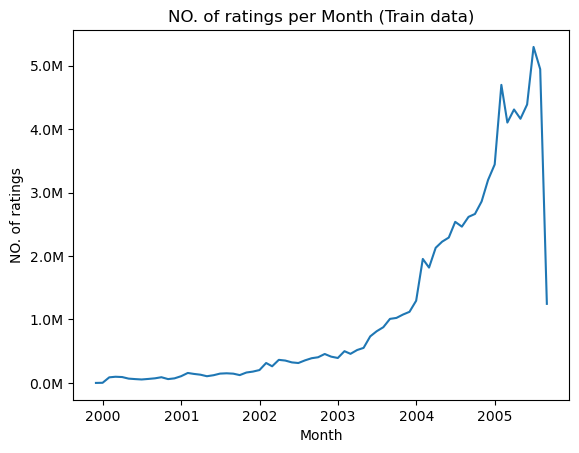

In [37]:
fig, ax = plt.subplots()
ax.plot(n_rating_per_month.index, n_rating_per_month.values)

ax.set_title('NO. of ratings per Month (Train data)')
ax.set_xlabel('Month')
ax.set_ylabel('NO. of ratings')
ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])
plt.show()

##### 2.2.3 Number of Ratings per User

In [43]:
n_rating_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

n_rating_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

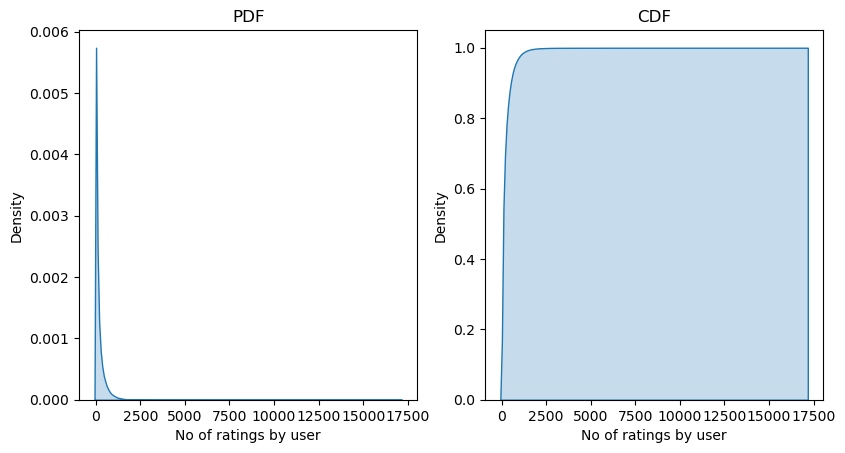

In [ ]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(n_rating_per_user, fill=True, ax=ax1)
plt.xlabel('NO. of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(n_rating_per_user, fill=True, cumulative=True, ax=ax2)
plt.xlabel('NO. of ratings by user')
plt.title('CDF')

plt.show()

##### 2.2.4 Number of ratings of a movie given by users

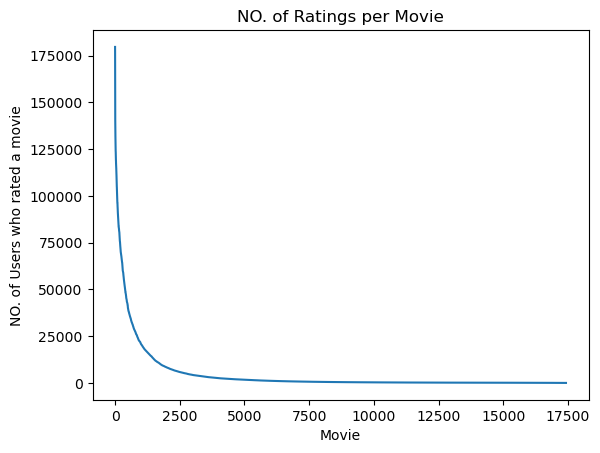

In [47]:
n_rating_per_movie = train_df.groupby('movie')['rating'].count().sort_values(ascending=False)

plt.plot(n_rating_per_movie.values)
plt.title('NO. of Ratings per Movie')
plt.xlabel('Movie')
plt.ylabel('NO. of Users who rated a movie')
plt.show()

##### 2.2.5 Number of ratings given on each day of a week

In [ ]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = 'warn'  # default='warn'

train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


C:\Users\Churou\AppData\Local\Temp\ipykernel_17320\2623182420.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])


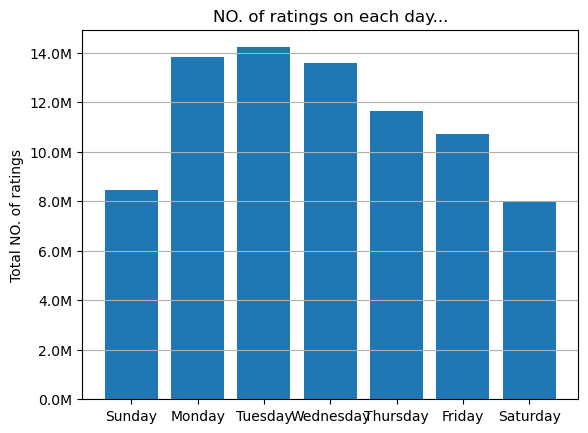

In [ ]:
week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

n_rating_each_day = train_df.groupby(by='day_of_week')['rating'].count()

# reorder by weekday
n_rating_each_day = n_rating_each_day.reindex(week_order)

fig, ax = plt.subplots()
bars = ax.bar(n_rating_each_day.index, n_rating_each_day.values)
plt.title('NO. of ratings on each day')
plt.ylabel('Total NO. of ratings')
plt.xlabel('')
ax.set_yticklabels([change_unit(i, 'M') for i in ax.get_yticks()])
ax.grid(axis='y')
plt.show()

##### 2.2.6 Average of Ratings on each day of a Week

In [56]:
avg_rating_each_day = train_df.groupby(by=['day_of_week'])['rating'].mean().sort_values()
print("Average ratings")
print("-"*30)
print(avg_rating_each_day)
print("\n")

Average ratings
------------------------------
day_of_week
Tuesday      3.574438
Monday       3.577250
Thursday     3.582463
Wednesday    3.583751
Friday       3.585274
Saturday     3.591791
Sunday       3.594144
Name: rating, dtype: float64




#### 2.3 Cold Start problem

In [ ]:
total_users = len(np.unique(df.user))
train_users = len(np.unique(train_df.user))
new_users = total_users - train_users

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', train_users)
print("\nNO. of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


In [ ]:
total_movies = len(np.unique(df.movie))
train_movies = len(np.unique(train_df.movie))
new_movies = total_movies - train_movies

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', train_movies)
print("\nNO. of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


### 3 Recommender System using Collaborative Filtering
#### 3.1 Preparation
##### 3.1.1 Create Sparse Matrix

In [2]:
def filter_active_users_movies(df, min_user_ratings=5, min_movie_ratings=5):
    """
    Filter out movies with more than 'min_movie_ratings' ratings 
    and users who left more than 'min_user_ratings' ratings.
    
    Args:
        df: user-movie ratings
        min_user_ratings: minimum # of ratings given by an 'active' user
        min_movie_ratings: minimum # of ratings of a 'popular' movie
    """
    print(f"Original data: # of comments: {df.shape[0]}, # of users: {df['user'].nunique()}, # of movies: {df['movie'].nunique()}")
    
    # Filtered out active users
    user_counts = df['user'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index
    df_filtered = df[df['user'].isin(active_users)]
    
    # Filtered out popular movies
    movie_counts = df_filtered['movie'].value_counts()
    popular_movies = movie_counts[movie_counts >= min_movie_ratings].index
    df_filtered = df_filtered[df_filtered['movie'].isin(popular_movies)]
    
    print(f"Filtered data: # of comments: {df_filtered.shape[0]}, # of users: {df_filtered['user'].nunique()}, # of movies: {df_filtered['movie'].nunique()}")
    
    return df_filtered

def create_sparse_user_movie_matrix(df, avg_rating_user, std_rating_user):
    """
    Create user-movie matrix (sparse)
    """

    df = df.copy()
    
    # normalization on rating
    df['rating_norm'] = ((df['rating'] - df['user'].map(avg_rating_user)) / df['user'].map(std_rating_user))

    # use 0 to replace NaN
    df['rating_norm'] = df['rating_norm'].fillna(0)

    # remap user and movie ids into new continuous numbers
    unique_users = df['user'].unique()
    unique_movies = df['movie'].unique()
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}
    
    # map new ids into original ids
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}
    
    print(f"Create a sparse matrix: {len(unique_users)} x {len(unique_movies)}")
    
    # creating sparse matrix
    rows = [user_to_idx[user] for user in df['user']]
    cols = [movie_to_idx[movie] for movie in df['movie']]
    data = df['rating_norm'].values
    
    sparse_matrix = csr_matrix((data, (rows, cols)), 
                              shape=(len(unique_users), len(unique_movies)))
    
    return sparse_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie

##### 3.1.2 Calculate Mean and Std for rating per user & movie

In [5]:
# average rating per user
avg_rating_per_user = train_df.groupby(by='user')['rating'].mean().round(2)
avg_rating_user = avg_rating_per_user.to_dict()

print('\nAverage rating of user 10 :', avg_rating_user.get(10))


Average rating of user 10 : 3.38


In [6]:
# std rating per user
std_rating_per_user = train_df.groupby(by='user')['rating'].std().round(2)
std_rating_user = std_rating_per_user.to_dict()

print('\nStandard Deviation of rating of user 10 :', std_rating_user.get(10))


Standard Deviation of rating of user 10 : 1.06


In [7]:
# average rating per movie
avg_rating_per_movie = train_df.groupby(by='movie')['rating'].mean().round(2)
avg_rating_movie = avg_rating_per_movie.to_dict()

print('\nAverage rating of movie 15 :', avg_rating_movie.get(15))


Average rating of movie 15 : 3.3


#### 3.2 Calculate similarity matrix for users

In [8]:
def compute_user_sim(sparse_matrix, batch_size=1000, k_neighbors=30):
    """
    Use batch to compute user-user similarity
    """
    n_users = sparse_matrix.shape[0]
    user_neighbors = {}
    
    print(f"Computing user similarities: (batch_size={batch_size}, k_neighbors={k_neighbors})")
    
    for start_idx in range(0, n_users, batch_size):
        end_idx = min(start_idx + batch_size, n_users)
        batch_users = sparse_matrix[start_idx:end_idx]
        
        print(f"Dealing with users: {start_idx}-{end_idx-1}/{n_users}")
        
        # compute similarities between users in this batch and all other users
        similarities = cosine_similarity(batch_users, sparse_matrix)
        
        # find K neighbours
        for i, user_idx in enumerate(range(start_idx, end_idx)):

            user_sims = similarities[i]
            
            # exclude user themselves
            user_sims[user_idx] = -1
            
            top_k_indices = np.argsort(user_sims)[-k_neighbors:][::-1]
            top_k_sims = user_sims[top_k_indices]
            
            # only keep positive similarities
            positive_indices = top_k_sims > 0
            if np.any(positive_indices):
                user_neighbors[user_idx] = {
                    neighbor: sim for neighbor, sim in 
                    zip(top_k_indices[positive_indices], top_k_sims[positive_indices])
                }
        
        # clear RAM
        del similarities
        gc.collect()
    
    return user_neighbors

#### 3.3 Prediction

In [8]:
def predict_sparse_batch(user_neighbors, sparse_matrix, test_df, 
                        user_to_idx, movie_to_idx, avg_rating_user, std_rating_user, batch_size=10000):
    """
    Batch prediction
    """
    predictions = []
    n_test = test_df.shape[0]
    
    print(f"Start predicting # {n_test} test data...")
    
    for start_idx in range(0, n_test, batch_size):
        end_idx = min(start_idx + batch_size, n_test)
        batch_test = test_df.iloc[start_idx:end_idx]
        
        if start_idx % 50000 == 0:
            print(f"Predicting process: {start_idx}/{n_test}")
        
        batch_predictions = []
        
        for _, row in batch_test.iterrows():
            user_id = row['user']
            movie_id = row['movie']
            actual_rating = row['rating']
            
            # check if the user and movie are in the dataset
            if user_id not in user_to_idx or movie_id not in movie_to_idx:
                batch_predictions.append(np.nan)
                continue
            
            user_idx = user_to_idx[user_id]
            movie_idx = movie_to_idx[movie_id]
            
            # check if user has neighbors
            if user_idx not in user_neighbors:
                batch_predictions.append(np.nan)
                continue
            
            # prediction
            weighted_sum = 0
            weight_sum = 0
            
            for neighbor_idx, similarity in user_neighbors[user_idx].items():
                neighbor_rating = sparse_matrix[neighbor_idx, movie_idx]
                if neighbor_rating != 0:  # no rating
                    weighted_sum += similarity * neighbor_rating
                    weight_sum += abs(similarity)
            
            if weight_sum > 0:
                pred = weighted_sum / weight_sum
                # counter-normalize
                user_mean = avg_rating_user.get(user_id, 3.0)  # default mean
                user_std = std_rating_user.get(user_id, 1.0)   # default std
                
                pred = pred * user_std + user_mean
                pred = np.clip(round(pred), 1, 5)
                batch_predictions.append(pred)
            else:
                batch_predictions.append(np.nan)
        
        predictions.extend(batch_predictions)
    
    # compute RMSE
    actual_ratings = test_df['rating'].values
    predictions = np.array(predictions)
    
    valid_mask = ~np.isnan(predictions)
    if np.any(valid_mask):
        mse = np.mean((predictions[valid_mask] - actual_ratings[valid_mask]) ** 2)
        rmse = np.sqrt(mse)
        coverage = np.mean(valid_mask)
        print(f"Prediction Coverage: {coverage:.2%}")
    else:
        rmse = np.nan
        coverage = 0
    
    return rmse, coverage

#### 3.4 Result measurement

In [ ]:
min_user_ratings=50   # increase this value to reduce # of users in train data
min_movie_ratings=50  # increase this value to reduce # of movies in train data
k_neighbors=30        # decrease this value to save RAM usage
batch_size=1000          # decrease this value to save RAM usage

import gc

print("=== Start Prediction ===")

# 1. Filter out active users and popular movies
filtered_train = filter_active_users_movies(train_df, min_user_ratings, min_movie_ratings)

# 2. Create sparse matrix
print("\nCreating user-movie rating sparse matrix...")
sparse_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie = create_sparse_user_movie_matrix(filtered_train, avg_rating_user, std_rating_user)

print(f"Density of the sparse matrix: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.4%}")

# 3. Batch computing user similarities
print("\nComputing user similarities...")

if not os.path.isfile('user_neighbors.npz'):
    user_neighbors = compute_user_sim(sparse_matrix, batch_size, k_neighbors)
    print(f"Find neighbours for {len(user_neighbors)} users")
else:
    user_neighbors = sparse.load_npz('user_neighbors.npz')


=== Start Prediction ===
Original data: # of comments: 80384405, # of users: 405041, # of movies: 17424
Filtered data: # of comments: 76971059, # of users: 263895, # of movies: 16720

Creating user-movie rating sparse matrix...
Create a sparse matrix: 263895 x 16720
Density of the sparse matrix: 1.7445%

Computing user similarities...


In [12]:
# 4. Evaluate on val dataset
print("\nEvaluating on val dataset...")
val_rmse, val_coverage = predict_sparse_batch(user_neighbors, sparse_matrix, val_df, 
                                              user_to_idx, movie_to_idx, avg_rating_user, std_rating_user)
print(f'Val dataset RMSE = {val_rmse:.4f}, coverage rate = {val_coverage:.2%}')

# 5. Evaluate on test dataset
print("\nEvaluate on test dataset...")
test_rmse, test_coverage = predict_sparse_batch(user_neighbors, sparse_matrix, test_df, 
                                               user_to_idx, movie_to_idx, avg_rating_user, std_rating_user)
print(f'Test dataset RMSE = {test_rmse:.4f}, coverate rate = {test_coverage:.2%}')


Evaluating on val dataset...
Start predicting # 10048051 test data...
Predicting process: 0/10048051
Predicting process: 50000/10048051
Predicting process: 100000/10048051
Predicting process: 150000/10048051
Predicting process: 200000/10048051
Predicting process: 250000/10048051
Predicting process: 300000/10048051
Predicting process: 350000/10048051
Predicting process: 400000/10048051
Predicting process: 450000/10048051
Predicting process: 500000/10048051
Predicting process: 550000/10048051
Predicting process: 600000/10048051
Predicting process: 650000/10048051
Predicting process: 700000/10048051
Predicting process: 750000/10048051
Predicting process: 800000/10048051
Predicting process: 850000/10048051
Predicting process: 900000/10048051
Predicting process: 950000/10048051
Predicting process: 1000000/10048051
Predicting process: 1050000/10048051
Predicting process: 1100000/10048051
Predicting process: 1150000/10048051
Predicting process: 1200000/10048051
Predicting process: 1250000/10

In [ ]:
# import gc

# print(f"RAM usage at the beginning: {get_memory_usage():.1f} MB")

# # adjust parameters 
# val_rmse, test_rmse, val_coverage, test_coverage = run_memory_optimized_evaluation(
#     avg_rating_user, std_rating_user,
#     min_user_ratings=30,    # increase this value to reduce # of users in train data
#     min_movie_ratings=30,   # increase this value to reduce # of movies in train data
#     k_neighbors=30,         # decrease this value to save RAM usage
#     batch_size=3000          # decrease this value to save RAM usage
# )

# print(f"RAM usage at the end: {get_memory_usage():.1f} MB")

# print(f"\n=== End Result ===")
# print(f"Val RMSE: {val_rmse:.4f} (coverage rate: {val_coverage:.2%})")
# print(f"Test RMSE: {test_rmse:.4f} (coverage rate: {test_coverage:.2%})")

开始时内存使用: 3090.9 MB
=== 内存优化的协同过滤评估 ===
原始数据: 80384405 条评分, 405041 用户, 17424 电影
过滤后: 80103766 条评分, 366042 用户, 17141 电影

创建稀疏用户-电影矩阵...
创建稀疏矩阵: 366042 x 17141
稀疏矩阵密度: 1.2767%

计算用户相似度...
分批计算用户相似度 (batch_size=1000, k_neighbors=30)
处理用户 0-999/366042
处理用户 1000-1999/366042
处理用户 2000-2999/366042
处理用户 3000-3999/366042
处理用户 4000-4999/366042
处理用户 5000-5999/366042
处理用户 6000-6999/366042
处理用户 7000-7999/366042
处理用户 8000-8999/366042
处理用户 9000-9999/366042
处理用户 10000-10999/366042
处理用户 11000-11999/366042
处理用户 12000-12999/366042
处理用户 13000-13999/366042
处理用户 14000-14999/366042
处理用户 15000-15999/366042
处理用户 16000-16999/366042
处理用户 17000-17999/366042
处理用户 18000-18999/366042
处理用户 19000-19999/366042
处理用户 20000-20999/366042
处理用户 21000-21999/366042
处理用户 22000-22999/366042
处理用户 23000-23999/366042
处理用户 24000-24999/366042
处理用户 25000-25999/366042
处理用户 26000-26999/366042
处理用户 27000-27999/366042
处理用户 28000-28999/366042
处理用户 29000-29999/366042
处理用户 30000-30999/366042
处理用户 31000-31999/366042
处理用户 32000-32999/366042
处理用

### 4. Machine Learning Methods

#### 4.1 Reducing dimensionality

In [10]:
# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=42)
trunc_svd = netflix_svd.fit_transform(sparse_matrix)

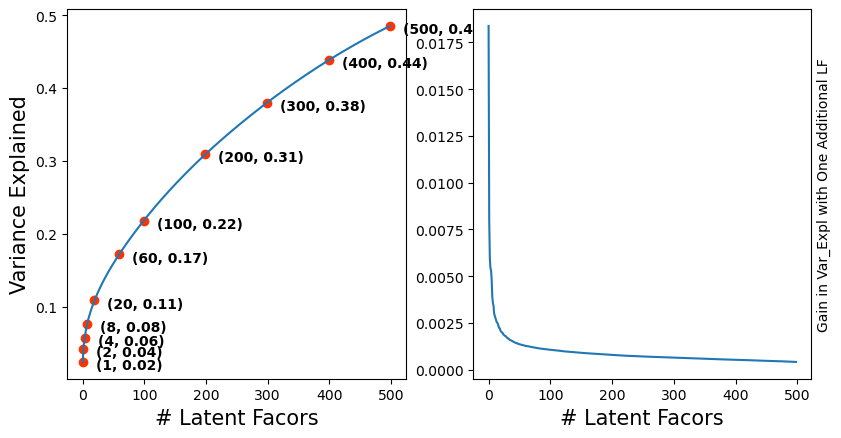

In [11]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate("({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
            xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)

ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=15)

plt.show()

500 dim can preserve 60% explained variance

In [15]:
trunc_matrix = sparse_matrix.dot(netflix_svd.components_.T)

print(type(trunc_matrix), trunc_matrix.shape)

<class 'numpy.ndarray'> (263895, 500)


##### 4.1.1 Convert the matrix into sparse matrix and save

In [ ]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

#### 4.2 Compute similarity matrix for users & movies

In [16]:
def to_sparse(user_neighbors, num_users):
    rows = []
    cols = []
    data = []

    for user, neighbors in user_neighbors.items():
        for neighbor, sim in neighbors.items():
            rows.append(user)
            cols.append(neighbor)
            data.append(sim)

    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(num_users, num_users))
    return sparse_matrix


In [13]:
if not os.path.isfile('user_neighbors.npz'):
    #user_neighbors = compute_user_sim(trunc_matrix, batch_size=1000, k_neighbors=30)
    user_neighbors = to_sparse(user_neighbors, sparse_matrix.shape[0])
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("user_neighbors.npz", user_neighbors)
    print("Done.")
else:
    user_neighbors = sparse.load_npz("user_neighbors.npz")
    print("Done.")

print("It's a ", user_neighbors.shape," dimensional matrix")

Done.
It's a  (263895, 263895)  dimensional matrix


In [14]:
if not os.path.isfile('movie_neighbors.npz'):
    #movie_neighbors = compute_user_sim(trunc_matrix.T, batch_size=1000, k_neighbors=30)
    movie_neighbors = compute_user_sim(sparse_matrix.T, batch_size=1000, k_neighbors=30)
    movie_neighbors = to_sparse(movie_neighbors, sparse_matrix.shape[1])
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("movie_neighbors.npz", movie_neighbors)
    print("Done.")
else:
    movie_neighbors = sparse.load_npz("movie_neighbors.npz")
    print("Done.")

print("It's a ", movie_neighbors.shape," dimensional matrix")


Done.
It's a  (16720, 16720)  dimensional matrix


#### 4.3 Featurizing train & test dataset

Note that:

    sparse_matrix: sparsed filtered train dataset df

    trunc_sparse_matrix: sparse matrix after dimensionality reducing (d = 500)

/# record the mapping from user_id and movie_id to ind used in sparse matrix

    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}

    movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}

-----------

Featurized dataset:

[user-movie]

1. GAvg: average rating of all ratings in the train data

2. Suser1, ..., Suser5: top 5 simiar users who rated that movie

3. Smov1, ..., Smov5: top 5 similar movies rated by this user

4. UAvg: this user's average rating

5. MAvg: this movie's average rating

6. rating(y): rating on this movie by this user

In [9]:
import csv

def featurize_dataset(path, df, train_rating_matrix, user_to_ind, movie_to_idx, user_neighbors, movie_neighbors, avg_rating_user, avg_rating_movie):
    
    if os.path.isfile(path):
        print("File already exists. Skipping.")
        return
    else:
        print('preparing {} tuples for the dataset..\n'.format(len(df)))

        with open(path, mode='w', newline='') as f:
            writer = csv.writer(f)
        
            # Write header
            header = [f"Suser{i}" for i in range(1, 6)] + \
                    [f"Smov{i}" for i in range(1, 6)] + \
                    ["UAvg", "MAvg", "rating"]
            writer.writerow(header)

            GAvg = df['rating'].mean().round(2)
            count = 0
            for row in df.itertuples():
                user_id = row.user
                movie_id = row.movie
                rating = row.rating

                user_idx = user_to_ind.get(user_id)
                movie_idx = movie_to_idx.get(movie_id)

                if user_idx is None or movie_idx is None:
                    continue
                
                # Suser1~5
                Suser = []
                u_neighbors = user_neighbors[user_idx].indices
                for neighbor_idx in u_neighbors:
                    if train_rating_matrix[neighbor_idx, movie_idx] > 0:
                        Suser.append(train_rating_matrix[neighbor_idx, movie_idx])
                    if len(Suser) == 5:
                        break
                while len(Suser) < 5:
                    Suser.append(GAvg)  # use avg rating to fill

                # Smov1~5
                Smov = []
                m_neighbors = movie_neighbors[movie_idx].indices
                for neighbor_idx in m_neighbors:
                    if train_rating_matrix[user_idx, neighbor_idx] > 0:
                        Smov.append(train_rating_matrix[user_idx, neighbor_idx])
                    if len(Smov) == 5:
                        break
                while len(Smov) < 5:
                    Smov.append(GAvg)

                UAvg = avg_rating_user.get(user_idx, GAvg)
                Mavg = avg_rating_movie.get(movie_id, GAvg)

                features = Suser + Smov + [UAvg, Mavg]
                features = features + [row.rating]


                count += 1
                writer.writerow(features)

                if (count)%10000 == 0:
                    # print(','.join(map(str, row)))
                    print("Done for {} rows".format(count))


In [32]:
featurize_dataset("train_features.csv", filtered_train, sparse_matrix, user_to_idx, movie_to_idx, user_neighbors, movie_neighbors, avg_rating_user, avg_rating_movie)

preparing 76971059 tuples for the dataset..

Done for 10000 rows
Done for 20000 rows
Done for 30000 rows
Done for 40000 rows
Done for 50000 rows
Done for 60000 rows
Done for 70000 rows
Done for 80000 rows
Done for 90000 rows
Done for 100000 rows
Done for 110000 rows
Done for 120000 rows
Done for 130000 rows
Done for 140000 rows
Done for 150000 rows
Done for 160000 rows
Done for 170000 rows
Done for 180000 rows
Done for 190000 rows
Done for 200000 rows
Done for 210000 rows
Done for 220000 rows
Done for 230000 rows
Done for 240000 rows
Done for 250000 rows
Done for 260000 rows
Done for 270000 rows
Done for 280000 rows
Done for 290000 rows
Done for 300000 rows
Done for 310000 rows
Done for 320000 rows
Done for 330000 rows
Done for 340000 rows
Done for 350000 rows
Done for 360000 rows
Done for 370000 rows
Done for 380000 rows
Done for 390000 rows
Done for 400000 rows
Done for 410000 rows
Done for 420000 rows
Done for 430000 rows
Done for 440000 rows
Done for 450000 rows
Done for 460000 row

In [11]:
# # 1. Reduce unactive users and movies with small # of ratings
filtered_test = filter_active_users_movies(test_df, min_user_ratings, min_movie_ratings)

Original data: # of comments: 10048051, # of users: 288028, # of movies: 17738
Filtered data: # of comments: 6972939, # of users: 50682, # of movies: 8074


In [15]:
featurize_dataset("test_features.csv", filtered_test, sparse_matrix, user_to_idx, movie_to_idx, user_neighbors, movie_neighbors, avg_rating_user, avg_rating_movie)

preparing 6972939 tuples for the dataset..

Done for 10000 rows
Done for 20000 rows
Done for 30000 rows
Done for 40000 rows
Done for 50000 rows
Done for 60000 rows
Done for 70000 rows
Done for 80000 rows
Done for 90000 rows
Done for 100000 rows
Done for 110000 rows
Done for 120000 rows
Done for 130000 rows
Done for 140000 rows
Done for 150000 rows
Done for 160000 rows
Done for 170000 rows
Done for 180000 rows
Done for 190000 rows
Done for 200000 rows
Done for 210000 rows
Done for 220000 rows
Done for 230000 rows
Done for 240000 rows
Done for 250000 rows
Done for 260000 rows
Done for 270000 rows
Done for 280000 rows
Done for 290000 rows
Done for 300000 rows
Done for 310000 rows
Done for 320000 rows
Done for 330000 rows
Done for 340000 rows
Done for 350000 rows
Done for 360000 rows
Done for 370000 rows
Done for 380000 rows
Done for 390000 rows
Done for 400000 rows
Done for 410000 rows
Done for 420000 rows
Done for 430000 rows
Done for 440000 rows
Done for 450000 rows
Done for 460000 rows

In [16]:
if os.path.isfile('train_features.csv'):
    train_featured = pd.read_csv('train_features.csv')
else:
    print("train_features.csv not found.")

print(f"featured train dataset shape: {train_featured.shape}")

if os.path.isfile('test_features.csv'):
    test_featured = pd.read_csv('test_features.csv')
else:
    print("test_features.csv not found.")

print(f"featured test dataset shape: {test_featured.shape}")

featured train dataset shape: (76971059, 13)
featured test dataset shape: (2384869, 13)


In [17]:
y_train_featured = train_featured['rating']
x_train_featured = train_featured.drop('rating', axis = 1)

y_test_featured = test_featured['rating']
x_test_featured = test_featured.drop('rating', axis = 1)

#### 4.4 Applying Machine Learning models

##### 4.4.1 XGBoost with 13 features

In [18]:
random.seed(42)

In [19]:
def get_error_metrics(y_true, y_pred):
    # mean sqared error
    rmse = np.sqrt(np.mean([(y_true[i] - y_pred[i])**2 for i in range(len(y_pred))]))
    # mean absolute percentage error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape

In [ ]:
#start = datetime.now()

model1 = xgb.XGBRegressor(n_jobs=13, random_state=42, n_estimators=100, eval_metric = 'rmse')
model1.fit(x_train_featured, y_train_featured)

y_train_pred = model1.predict(x_train_featured)
# get the rmse and mape of train data...
rmse_train, mape_train = get_error_metrics(y_train_featured.values, y_train_pred)

model1_train_results = {'rmse': rmse_train,
                        'mape' : mape_train,
                        'predictions' : y_train_pred}

# ---------
y_test_pred = model1.predict(x_test_featured) 
# get the rmse and mape of train data...
rmse_test, mape_test = get_error_metrics(y_test_featured.values, y_pred=y_test_pred)

model1_test_results = {'rmse': rmse_test,
                        'mape' : mape_test,
                        'predictions':y_test_pred}

print('Total time taken:', datetime.now() - start)
print('Train data:')
print(f'RMSE: {model1_train_results['rmse']}\n MAPE: {model1_train_results['mape']}')
print()
print('Test data:')
print(f'RMSE: {model1_test_results['rmse']}\n MAPE: {model1_test_results['mape']}')

c:\Users\Churou\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Total time taken: 0:05:07.210538
Train data:
RMSE: 0.9328664129708346
 MAPE: 28.75088745506595

Test data:
RMSE: 1.0240988083393336
 MAPE: 28.429940143013923


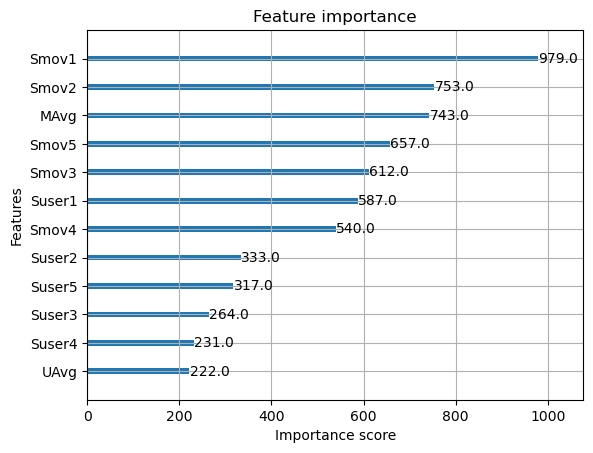

In [24]:
xgb.plot_importance(model1)
plt.show()

In [ ]:
# print("-" * 100)
# print("Total time taken to run this entire notebook ( with saved files) is :", 
#         datetime.now() - globalstart)